# Sea ice-water discrimination
Along with ice floes, we want to be able to distinguish, where possible, the water and ice pixels in each image. This will help us test a few steps in the IFT algorithm, for example. To avoid needing to manually draw the masks in Photoshop, I'd like to see whether it's possible to merge the existing masks and derive some information based on the Normalized Difference Snow and Ice Index (NDSII). Whereas the floe labels will sometimes include heavily obscured images, the ice/water masks will only include locations where the sea ice and water can be distinguished with high confidence.

In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
import skimage
from scipy.interpolate import interp1d

# preliminaries
region_order = ['greenland_sea', 'barents_kara_seas', 'laptev_sea', 'sea_of_okhostk',
                'east_siberian_sea', 'bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'baffin_bay']

title_case = {'baffin_bay': 'Baffin Bay',
              'barents_kara_seas': 'Barents-Kara Seas',
              'beaufort_sea': 'Beaufort Sea',
              'bering_chukchi_seas': 'Bering-Chukchi Seas',
              'east_siberian_sea': 'East Siberian Sea',
              'greenland_sea': 'Greenland Sea',
              'hudson_bay': 'Hudson Bay',
              'laptev_sea': 'Laptev Sea',
              'sea_of_okhostk': 'Sea of Okhostk'}

# load the list of cloud clearing evaluation cases
dataloc = '../../ice_floe_validation_dataset/'
df = pd.read_csv(dataloc + '/data/validation_dataset/validation_dataset.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['seaice', 'landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, 'masie', imtype, '250m', 'tiff'])        

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'

lm_dataloc = dataloc + 'data/validation_dataset/binary_landmask/'
lb_dataloc = dataloc + 'data/validation_dataset/binary_floes/'
lf_dataloc = dataloc + 'data/validation_dataset/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/seaice/'
masie_land_loc = dataloc + 'data/masie/landmask/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc,
                                           lb_dataloc, lf_dataloc, lm_dataloc,
                                           masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction',
                                           'binary_floes', 'binary_landfast', 'binary_landmask',
                                           'seaice', 'landmask'],
                                          [tc_images, fc_images, cl_images,
                                           lb_images, lf_images, lm_images,
                                           mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype in ['seaice', 'landmask']: # masie images
                missing.append(fname(df.loc[row,:], imtype))

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [3]:
df.loc[df.visible_sea_ice == 'yes']

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,floe_obscuration,landfast_obscuration,modis_cloud_error,notes
001_terra,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.000,0.573,...,yes,daniel,emma,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
001_aqua,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.000,0.573,...,yes,ethan,daniel,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
002_terra,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.000,0.858,...,no,daniel,emma,NaN,NaN,NaN,NaN,NaN,no,NaN
002_aqua,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.000,0.858,...,no,ethan,daniel,NaN,NaN,NaN,NaN,NaN,no,NaN
003_terra,003,baffin_bay,2012-04-19,-79.579288,75.637235,-887500,-1287500,4,1.000,0.873,...,yes,daniel,emma,NaN,NaN,NaN,NaN,heavy,no,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187_terra,187,sea_of_okhostk,2013-04-29,155.730955,59.727751,-1187500,3137500,4,0.609,0.612,...,no,daniel,minki,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188_aqua,188,sea_of_okhostk,2015-03-12,156.838398,57.660804,-1337500,3337500,3,1.000,0.660,...,no,daniel,minki,daniel,NaN,yes,heavy,NaN,NaN,floe outlines unclear -- checked against false...
188_terra,188,sea_of_okhostk,2015-03-12,156.838398,57.660804,-1337500,3337500,3,1.000,0.660,...,yes,daniel,minki,daniel,NaN,yes,moderate,NaN,NaN,NaN
189_aqua,189,sea_of_okhostk,2012-04-26,163.085821,61.417181,-1487500,2787500,4,1.000,0.778,...,no,daniel,minki,daniel,NaN,yes,light,NaN,NaN,NaN


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_10517/426933456.py:6: RuntimeWarning: divide by zero encountered in divide
  ndsii = (b2 - b7)/(b2 + b7)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_10517/426933456.py:6: RuntimeWarning: invalid value encountered in divide
  ndsii = (b2 - b7)/(b2 + b7)


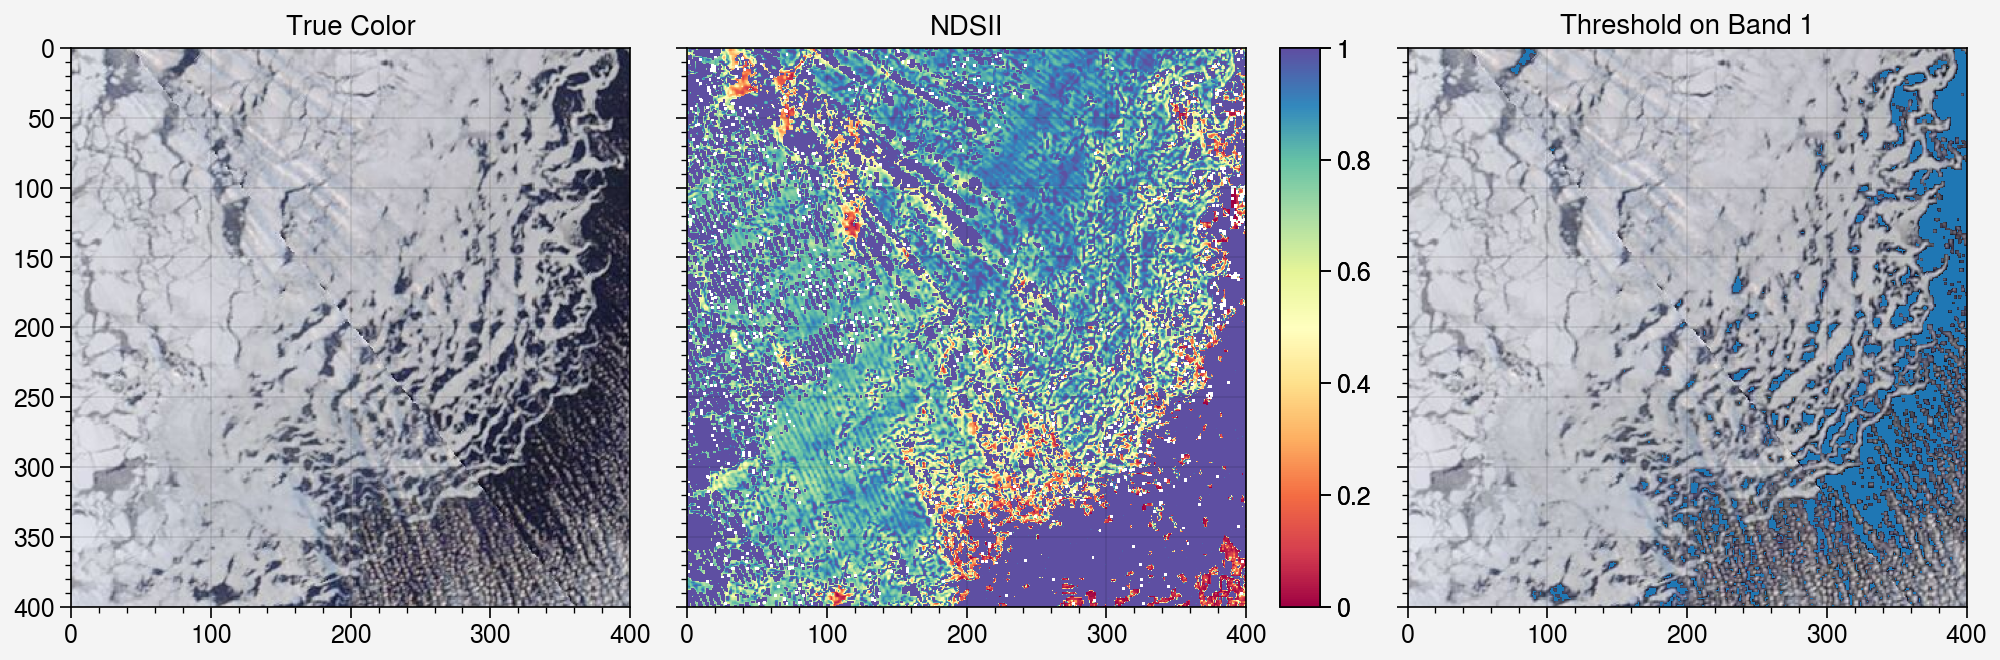

In [12]:
case = '025_terra'
b1 = fc_images[case][2, :, :]
b7 = fc_images[case][0, :, :]
b2 = fc_images[case][1, :, :]
b4 = tc_images[case][1, :, :]
ndsii = (b2 - b7)/(b2 + b7)
# ndsii[b2 + b7 < 1] = 0
# ndsii[ndsii < 0.8] = np.nan

fig, axs = pplt.subplots(width=10, ncols=3)
axs[0].imshow(reshape_as_image(tc_images[case]), extent=[0, 400, 400, 0])
land = (lm_images[case].squeeze() > 0).astype(int)
axs[0].imshow(np.ma.masked_array(land, land==0), color='k', alpha=0.75, extent=[0, 400, 400, 0])

axs[1].imshow(ndsii, vmin=0, vmax=1, extent=[0, 400, 400, 0], zorder=0, colorbar='r', cmap='spectral')
axs[1].imshow
if case in lb_images:
    manual_floe_labels = lb_images[case][0,:,:] % 2
    outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
axs[2].imshow(reshape_as_image(tc_images[case]), extent=[0, 400, 400, 0])
axs[2].imshow(np.ma.masked_array((b1 > 50).astype(int),mask=b1 > 50), color='tab:blue', extent=[0, 400, 400, 0], zorder=2)
for ax in axs:
    ax.imshow(np.ma.masked_array(land, land==0), color='k', alpha=0.75, extent=[0, 400, 400, 0], zorder=1)
    if case in lb_images:
        ax.imshow(np.ma.masked_array(outlines, outlines==0), color='r', zorder=4)
    # add landfast?
axs[0].format(title='True Color')
axs[1].format(title='NDSII')

axs[2].format(title='Threshold on Band 1')


# Notes on interesting cases
* 001: sharp difference in cloud vs water pixels. Ice NDSII midrange.
* 002: no distinct floes; ice formation in fjord. Ice NDSII near 1.
* 003: no distinct floes, small patch of discernable water, landfast ice NDSII near 1.
* 005: Landfast ice saturated; clouds also saturated. Sea ice pixels all above 0.4.
* 007: Band 1 threshold works pretty well, NDSII ambiguous.
* 012: thin clouds over water, so a higher threshold needed
* 025: Ocean pixels all at 1??
* 048: Ocean pixels hit extremes. Is the formula correct? Here, using a threshold of 50 on band 1 seems pretty effective.

Next steps, for 048, look at the histograms in particular bands.

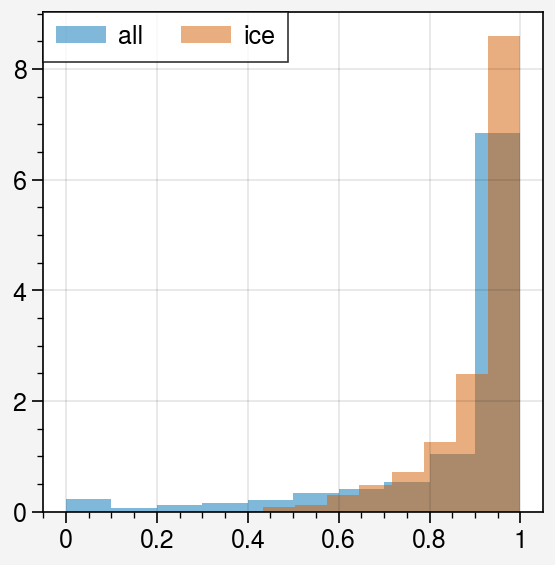

In [5]:
fig, ax = pplt.subplots()
ndsii[ndsii >= 1] = 1
ice = np.ravel(lb_images[case][0,:,:] > 0)

ax.hist(np.ravel(ndsii), density=True, alpha=0.5, label='all')
ax.hist(np.ravel(ndsii)[ice], density=True, alpha=0.5, label='ice')
ax.legend()

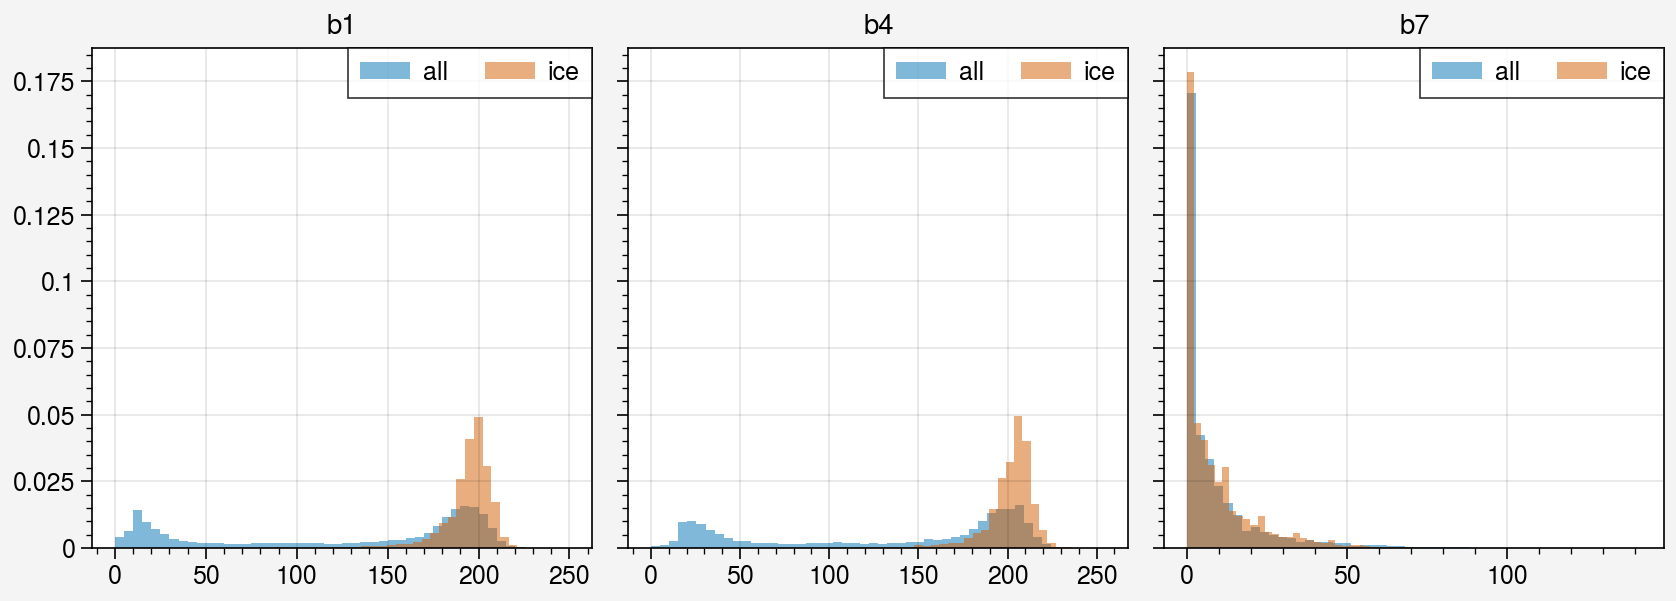

In [6]:
fig, axs = pplt.subplots(ncols=3)
b1 = tc_images[case][0,:,:]
b4 = tc_images[case][1,:,:]
b2 = fc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
ice = np.ravel(lb_images[case][0,:,:] > 0)
for ax, b, title in zip(axs, [b1, b4, b7], ['b1', 'b4', 'b7']):
    ax.hist(np.ravel(b), density=True, alpha=0.5, label='all', bins=50)
    ax.hist(np.ravel(b)[ice], density=True, alpha=0.5, label='ice', bins=50)
    ax.legend()
    ax.format(title=title)

In [7]:
bandwidths = {'b1': 0.5 * (620 + 670), 
              'b2': 0.5 * (841 + 876), 
              'b3': 0.5 * (459 + 479), 
              'b4': 0.5 * (545 + 565),
              'b7': 0.5 * (2105 + 2155)}
print(bandwidths)

{'b1': 645.0, 'b2': 858.5, 'b3': 469.0, 'b4': 555.0, 'b7': 2130.0}


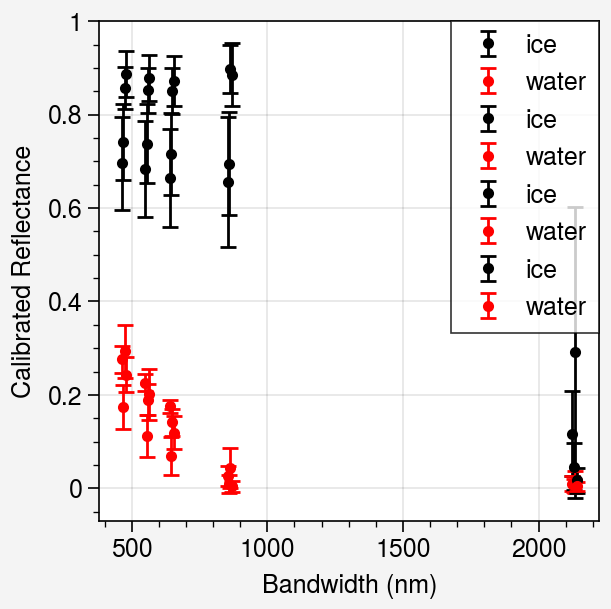

In [8]:
fig, ax = pplt.subplots()
offset = -5
for case in ['004_terra', '011_terra', '013_terra', '048_terra']:
    land = np.ravel(lm_images[case][0,:,:] > 0)
    banddata = {
        'b1': tc_images[case][0,:,:]/255,
        'b2': fc_images[case][1,:,:]/255,
        'b3': tc_images[case][2,:,:]/255,
        'b4': tc_images[case][1,:,:]/255,
        'b7': fc_images[case][0,:,:]/255}
    
    
    ice = lb_images[case][0,:,:] > 0
    water = (banddata['b1'] < 50/255) & (lm_images[case][0,:,:] == 0)
    
    
    for category, label, c in zip([ice, water], ['ice', 'water'], ['k', 'r']):
        bw = [bandwidths[band] + offset for band in bandwidths]
        bmean = [np.mean(banddata[band][category]) for band in bandwidths]
        bstd = [np.std(banddata[band][category]) for band in bandwidths]
        ax.errorbar(x=bw, y=bmean, yerr=bstd, lw=0, marker='.', elinewidth=1, label=label, color=c)
    offset += 5
    ax.legend(ncols=1)
    ax.format(xscale='linear', xlabel='Bandwidth (nm)', ylabel='Calibrated Reflectance')
    
    # TBD: get cloud labels also
    # See about ways to aggregate across images, check differences in season

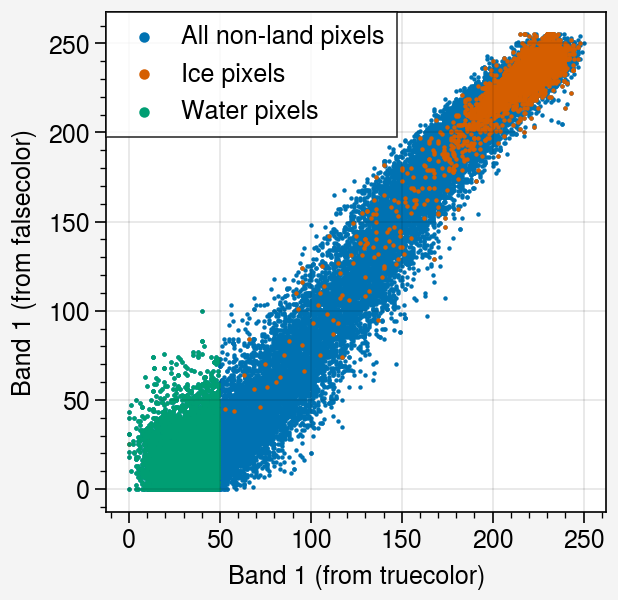

In [9]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ice = np.ravel(lb_images[case][0,:,:] >0)
water = np.ravel(tc_images[case][0,:,:] < 50)

ax.scatter(np.ravel(tc_images[case][0,:,:])[~land],
           np.ravel(fc_images[case][2,:,:])[~land], ms=1, label='All non-land pixels')


ax.scatter(np.ravel(tc_images[case][0,:,:])[ice],
           np.ravel(fc_images[case][2,:,:])[ice], ms=1, label='Ice pixels')
ax.scatter(np.ravel(tc_images[case][0,:,:])[water],
           np.ravel(fc_images[case][2,:,:])[water], ms=1, label='Water pixels')

ax.format(xlabel='Band 1 (from truecolor)', ylabel='Band 1 (from falsecolor)')
ax.legend(ncols=1, ms=10)

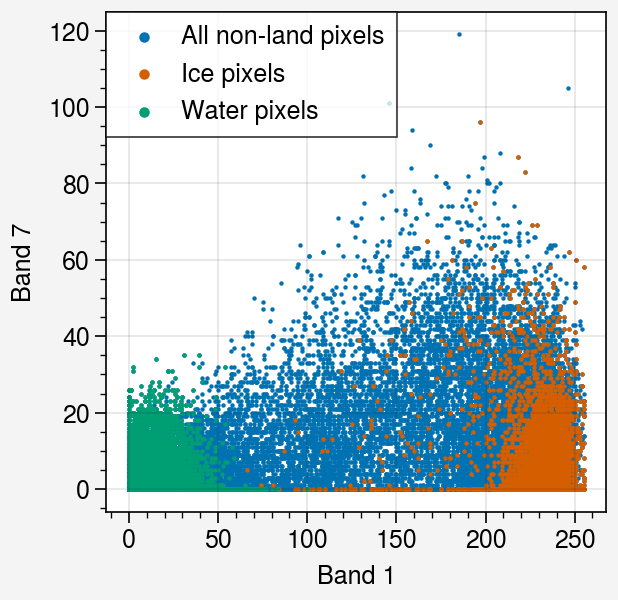

In [10]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[~land],
           np.ravel(fc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')

ice = np.ravel(lb_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[ice],
           np.ravel(fc_images[case][0,:,:])[ice], ms=1, label='Ice pixels')

ax.scatter(np.ravel(fc_images[case][2,:,:])[water],
           np.ravel(fc_images[case][0,:,:])[water], ms=1, label='Water pixels')
ax.format(xlabel='Band 1', ylabel='Band 7')
ax.legend(ncols=1, ms=10)

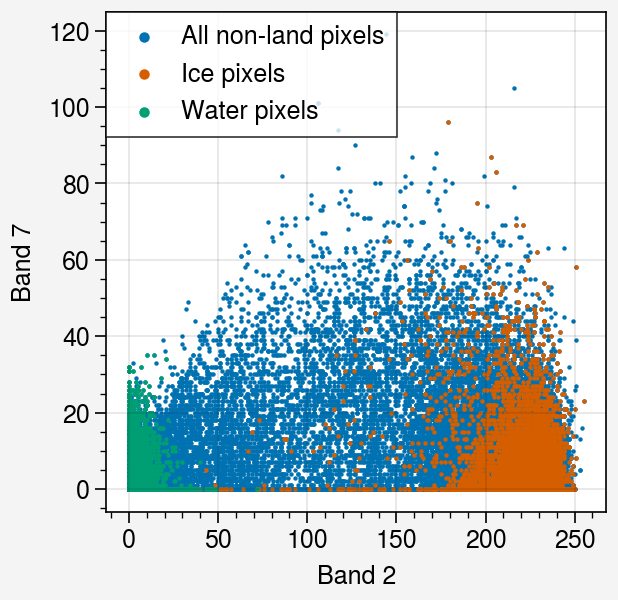

In [181]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][1,:,:])[~land],
           np.ravel(fc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')

ice = np.ravel(lb_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][1,:,:])[ice],
           np.ravel(fc_images[case][0,:,:])[ice], ms=1, label='Ice pixels')

ax.scatter(np.ravel(fc_images[case][1,:,:])[water],
           np.ravel(fc_images[case][0,:,:])[water], ms=1, label='Water pixels')

ax.format(xlabel='Band 2', ylabel='Band 7')
ax.legend(ncols=1, ms=10)

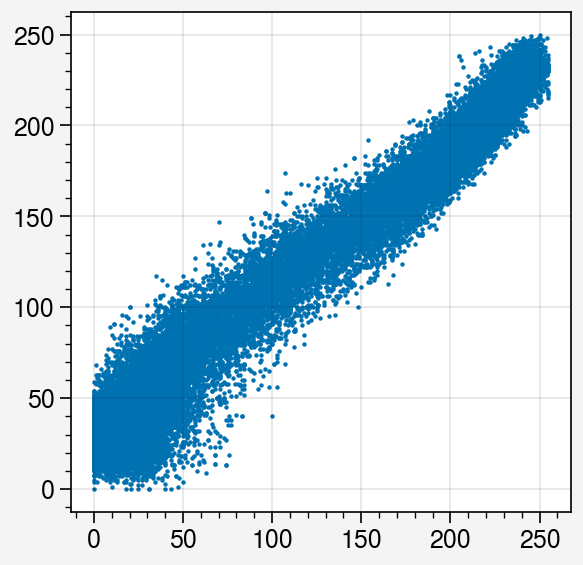

In [185]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[~land],
           np.ravel(tc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')
